# Práctica de Deep Learning 101
### *Alumno: David Jiménez Vicente*

---

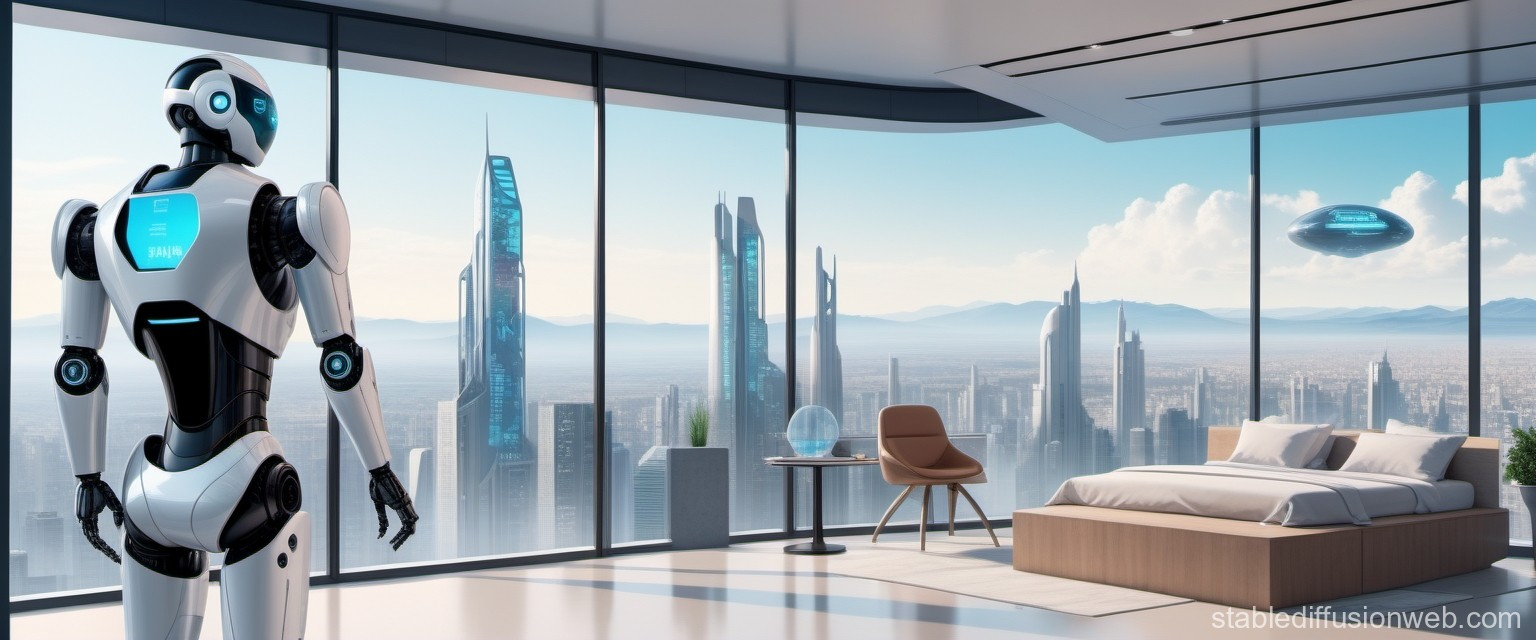

#### El objetivo de la práctica final del módulo de Deep Learning consiste en solucionar un problema del mundo real usando las técnicas vistas en clase. En concreto, lo que se pretende es tratar de predecir el precio de habitaciones de AirBnb utilizando para ello todas las características disponibles en el dataset.

#### Se pide concretamente fusionar en un único modelo dos modelos previos, uno para predecir en base imágenes y otro en base a datos tabulares. Este modelo final predecirá el resultado final en base a los cálculos previos de las dos redes anteriores.

---

---

<h2 align=center>ETAPA 1: CARGA Y PREPROCESADO DE LOS DATOS</h2>

## 1.- Importación de datos

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import cv2
import imageio.v3 as io
from tqdm import tqdm
from typing import Optional, Union

In [2]:
url="https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"
df = pd.read_csv(url, sep=";")

In [3]:
df.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,6219524,https://www.airbnb.com/rooms/6219524,20170407214119,2017-04-08,"BAILÉN II, Madrid, Friendly Rentals",Situado en una de las zonas monumentales más b...,This apartment is in an unbeatable location fu...,This apartment is in an unbeatable location fu...,none,"Surrounded by fashionable, original restaurant...",...,10.0,10.0,10.0,NaN,NaN,strict,145,0.11,"40.412684773008245,-3.712816253129112","Host Has Profile Pic,Is Location Exact,Require..."
1,16474980,https://www.airbnb.com/rooms/16474980,20170407214119,2017-04-08,TOP FLAT in calle Mayor,"Studio in the centre of Madrid, close to Plaza...",Entire refurbished apartment. Modern and silen...,"Studio in the centre of Madrid, close to Plaza...",none,"In the very centre of Madrid, the house is loc...",...,10.0,10.0,10.0,NaN,NaN,moderate,4,7.59,"40.415372032216105,-3.709730059105588","Host Has Profile Pic,Requires License,Instant ..."
2,6832931,https://www.airbnb.com/rooms/6832931,20170407214119,2017-04-08,Apto.centro Madrid (Latina) 4 pax.,"Apto. de diseño, dos dormitorios zona La Latin...",Mínimo alquiler por semanas/ Rent minimum for ...,"Apto. de diseño, dos dormitorios zona La Latin...",none,Es un gran barrio desde donde nos podemos move...,...,NaN,NaN,NaN,NaN,NaN,strict,1,NaN,"40.4107932767247,-3.7096063407900335","Host Has Profile Pic,Is Location Exact,Require..."
3,11359451,https://www.airbnb.com/rooms/11359451,20170407214119,2017-04-08,Room for 2 in Gran Vía,Fantástico piso situado en pleno corazón de Ma...,NaN,Fantástico piso situado en pleno corazón de Ma...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,8,NaN,"40.42260038355819,-3.7107182918290675","Host Has Profile Pic,Host Identity Verified,Re..."
4,17693064,https://www.airbnb.com/rooms/17693064,20170407214119,2017-04-08,"BARCELO III, by Friendly Rentals",Lugares de interés: Museo Nacional del Romanti...,Apartamento de un dormitorio en pleno corazón ...,Lugares de interés: Museo Nacional del Romanti...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,strict,145,NaN,"40.426272804917524,-3.700098453855452","Host Has Profile Pic,Is Location Exact,Require..."


## 2.- EDA y Preproc

*Realizaré el EDA y el Preproc antes de hacer la división de los datos entre Train y Test, sin contaminar el entrenamiento, para que ambos datasets tengan estructuras similares. Las mismas directrices de Preprocesado, Selección de características y Transformación, así como Nuevas características se aplicarán a los datos nuevos una vez en producción.*

Todo Preproc que, para crear nuevas features o modificar los valores reales, no use una combinación de los valores reales de las observaciones no contaminará los resultados de test. Operaciones como One Hot Encoding en base a categorías existentes, o a intervalos de valores cerrados no calculados en base a los valores presentes, no pueden contaminar los datos de train aunque se realize antes del split, ya que si una observación es de una clase, seguirá siendo de esa clase hayan estado los datos de test presentes o no, ya que no dependen de la interacción entre los valores medidos en el dataset.  
En cambio, operaciones como One Hot en base a N divisiones entre el mínimo y el máximo presente, o normalizaciones, o imputación de NaNs usando medias, etc... han de realizarse tras el split, ya que sí dependen de la interacción entre los valores reales del dataset.

In [4]:
# Veamos qué campos tiene el dataset:
df.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [5]:
# Con el parámetro include="all", .describe() también dará info acerca de las variables categóricas:
df.describe(include="all")

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
count,1.400100e+04,14001,1.400100e+04,14001,14001,13451,10306,13995,14001,8630,...,10848.000000,10830.000000,10828.000000,333,0.0,14001,14001.000000,10994.000000,14001,14001
unique,NaN,14001,NaN,2,13600,12565,9601,13510,1,7438,...,NaN,NaN,NaN,314,NaN,5,NaN,NaN,14001,60
top,NaN,https://www.airbnb.com/rooms/6219524,NaN,2017-04-08,Apartamento en el centro de Madrid,"Unique apartment in vibrant neighborhoods, car...",Los Apartamentos Good Stay Prado se encuentran...,Es un piso con 6 habitaciones de las que 5 ha...,none,Se trata de una de las zonas más emblemáticas ...,...,NaN,NaN,NaN,HUTB-009034,NaN,strict,NaN,NaN,"40.412684773008245,-3.712816253129112","Host Has Profile Pic,Host Identity Verified,Is..."
freq,NaN,1,NaN,13625,12,64,29,19,14001,32,...,NaN,NaN,NaN,5,NaN,5474,NaN,NaN,1,2498
mean,1.034537e+07,NaN,2.017040e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.640395,9.532872,9.207702,NaN,NaN,NaN,9.829298,1.881707,NaN,NaN
std,5.557061e+06,NaN,1.489419e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.771973,0.777239,0.957385,NaN,NaN,NaN,24.196777,1.871766,NaN,NaN
min,1.862800e+04,NaN,2.017032e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,2.000000,2.000000,NaN,NaN,NaN,1.000000,0.020000,NaN,NaN
25%,5.639157e+06,NaN,2.017041e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.000000,9.000000,9.000000,NaN,NaN,NaN,1.000000,0.460000,NaN,NaN
50%,1.146724e+07,NaN,2.017041e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,10.000000,9.000000,NaN,NaN,NaN,2.000000,1.220000,NaN,NaN
75%,1.536912e+07,NaN,2.017041e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,10.000000,10.000000,NaN,NaN,NaN,5.000000,2.810000,NaN,NaN


*· Tiene demasiadas características para poder extraer información rápidamente. Se necesita hacer una primera selección de características.*  
· Empezaré por comprobar las ciudades presentes en el dataset:

In [6]:
# Buscaremos los valores únicos en el campo "City"
df.City.sort_values().unique()

array(['Alaró', 'Alcudia', 'Alcúdia', 'Algaida', 'Andratx', 'Aravaca',
       'Aravaca (Madrid)', 'Ariany', 'Balearic Islands', 'Barcelona',
       'Betlem', 'Biniamar', 'Binissalem', 'Binissalem-Mallorca DO',
       'Boadilla del Monte', 'Bunyola', 'Búger', 'Caimari', 'Cala Agulla',
       'Cala Anguila-Cala Mendia', 'Cala Ferrera', 'Cala Magrana',
       'Cala Murada', 'Cala Pi', 'Cala Ratjada', 'Cala Santanyí',
       'Calvià', 'Campanet', 'Campos', 'Can Pastilla', 'Can Picafort',
       'Centro', 'Centro, Madrid', 'Chiva', 'Chueca', 'Chueca, Madrid',
       'Colonia Sant Pere', 'Colonia de Sant Pere',
       'Colònia de Sant Jordi', 'Comunidad de Madrid', 'Costa dels Pins',
       'Costitx', 'Deià', 'Delicias', 'Delicias-Madrid', 'Deyá',
       'El Toro', 'Felanitx', 'Font de Sa Cala',
       'Hospitalet de Llobregat', 'Illes Balears', 'Illetes', 'Inca',
       'La Elipa', 'La Puebla', 'Lloret de Vistalegre', 'Lloseta',
       'Llubí', 'Llucalcari', 'Llucmajor', 'MADRID', 'Madid', 

In [7]:
df.City.value_counts()

City
Madrid              13207
Barcelona             292
马德里                    52
Palma                  49
Alcúdia                40
                    ...  
villa verde bajo        1
Chiva                   1
Aravaca (Madrid)        1
La Elipa                1
Cala Murada             1
Name: count, Length: 135, dtype: int64

Claramente, las categorías de City están muy desbalanceadas. Sólo usaré Madrid para que el modelo sea representativo.  
Además, aparecen varias maneras de referirse a Madrid, pero todas parecen contener los caracteres "mad".  
También hay barrios de Madrid inscritos en el campo Ciudad. Haré un primer filtrado con eso.

In [153]:
# Seleccionamos por los caracteres "mad" o las locvalizaciones que pertenecen a Madrid erróneamente clasificadas. Esto debería evitarse en el frontend en producción.
df_madrid = df[df.City.str.contains("Mad") | df.City.str.contains("mad") | df.City.str.contains("MAD") | df.City.str.contains("Aravaca") | df.City.str.contains("villa verde bajo") | df.City.str.contains("Chueca") | df.City.str.contains("Ventas") | df.City.str.contains("Boadilla") | df.City.str.contains("Elipa") | df.City.str.contains("Pozuelo") | df.City.str.contains("de Henares") | df.City.str.contains("Delicias")]
df_madrid.City.sort_values().unique()

array(['Aravaca', 'Aravaca (Madrid)', 'Boadilla del Monte',
       'Centro, Madrid', 'Chueca', 'Chueca, Madrid',
       'Comunidad de Madrid', 'Delicias', 'Delicias-Madrid', 'La Elipa',
       'MADRID', 'Madid', 'Madri', 'Madrid',
       'Madrid, Comunidad de Madrid, ES',
       'Madrid, Comunidad de Madrid, ESPANA',
       'Madrid, Vallecas (Fontarrón)', 'Pozuelo', 'Pozuelo de Alarcón',
       'San Fernando de Henares', 'Ventas', 'las matas  madrid', 'madrid',
       'villa verde bajo'], dtype=object)

In [154]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13263 entries, 0 to 13999
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              13263 non-null  int64  
 1   Listing Url                     13263 non-null  object 
 2   Scrape ID                       13263 non-null  int64  
 3   Last Scraped                    13263 non-null  object 
 4   Name                            13263 non-null  object 
 5   Summary                         12775 non-null  object 
 6   Space                           9684 non-null   object 
 7   Description                     13257 non-null  object 
 8   Experiences Offered             13263 non-null  object 
 9   Neighborhood Overview           8304 non-null   object 
 10  Notes                           5032 non-null   object 
 11  Transit                         8257 non-null   object 
 12  Access                          7541 

Ahora eliminaré la columna "City", ya que ya no es necesaria, junto con otras:

Eliminaremos características con poca relación con las caraterísticas del piso, como features que sólo son datos de registro o tracking de los scraps, y también variables de texto subjetivo como las descripciones del propietario sobre el piso, vecindario, ciudad, etc.... que no comparten valores comunes entre los registros. Así mismo, muchas variables de localización son redundantes. Eliminaré también aquellas con alto número de NaNs o que sean redundantes por referisrse al mismo tipo de variable.

In [155]:
df_madrid = df_madrid[["Thumbnail Url", "Host Total Listings Count", "Neighbourhood Group Cleansed", "Property Type", "Room Type", "Accommodates", "Bathrooms", "Beds", "Bedrooms", "Amenities", "Security Deposit", "Cleaning Fee", "Guests Included"
                 ,"Extra People", "Minimum Nights", "Maximum Nights", "Availability 30", "Number of Reviews", "Cancellation Policy", "Price"]]

In [156]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13263 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10778 non-null  object 
 1   Host Total Listings Count     13260 non-null  float64
 2   Neighbourhood Group Cleansed  13263 non-null  object 
 3   Property Type                 13263 non-null  object 
 4   Room Type                     13263 non-null  object 
 5   Accommodates                  13263 non-null  int64  
 6   Bathrooms                     13214 non-null  float64
 7   Beds                          13214 non-null  float64
 8   Bedrooms                      13240 non-null  float64
 9   Amenities                     13154 non-null  object 
 10  Security Deposit              5645 non-null   float64
 11  Cleaning Fee                  7845 non-null   float64
 12  Guests Included               13263 non-null  int64  
 13  Extra 

Usando el conocimiento del dominio, sabemos que hay dos variables que sus valores NaN son realmente valor 0: "Security Deposit" y "Cleaning Fee" son dos tasas que el cliente ha de activar proactivamente si las quiere cobrar, por lo que aceptamos correcto asumir que si no lo marcan es que el precio de esas dos tasas es 0, ya que no lo quiere cobrar. Por lo tanto, en estas dos sustituiremos los NaN por 0, y lo haré antes del split ya que la imputación no tiene que ver con el resto de los valores presentes en el dataset, si no que depende de la propia naturaleza de la variable:

In [157]:
df_madrid["Cleaning Fee"] = df_madrid["Cleaning Fee"].fillna(0)
df_madrid["Security Deposit"] = df_madrid["Security Deposit"].fillna(0)
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13263 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10778 non-null  object 
 1   Host Total Listings Count     13260 non-null  float64
 2   Neighbourhood Group Cleansed  13263 non-null  object 
 3   Property Type                 13263 non-null  object 
 4   Room Type                     13263 non-null  object 
 5   Accommodates                  13263 non-null  int64  
 6   Bathrooms                     13214 non-null  float64
 7   Beds                          13214 non-null  float64
 8   Bedrooms                      13240 non-null  float64
 9   Amenities                     13154 non-null  object 
 10  Security Deposit              13263 non-null  float64
 11  Cleaning Fee                  13263 non-null  float64
 12  Guests Included               13263 non-null  int64  
 13  Extra 

Empezando por los NaNs, nos quedan pocas variables con muy pocos NaNs, así que eliminaré esos registros, que son un pequeño porcentaje.

In [158]:
# Empezaré eliminando las filas de la que tiene más, a ver si elimina los NaNs de otras variables:
df_madrid = df_madrid[df_madrid["Amenities"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13154 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10704 non-null  object 
 1   Host Total Listings Count     13151 non-null  float64
 2   Neighbourhood Group Cleansed  13154 non-null  object 
 3   Property Type                 13154 non-null  object 
 4   Room Type                     13154 non-null  object 
 5   Accommodates                  13154 non-null  int64  
 6   Bathrooms                     13128 non-null  float64
 7   Beds                          13124 non-null  float64
 8   Bedrooms                      13131 non-null  float64
 9   Amenities                     13154 non-null  object 
 10  Security Deposit              13154 non-null  float64
 11  Cleaning Fee                  13154 non-null  float64
 12  Guests Included               13154 non-null  int64  
 13  Extra 

In [159]:
df_madrid = df_madrid[df_madrid["Host Total Listings Count"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13151 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10701 non-null  object 
 1   Host Total Listings Count     13151 non-null  float64
 2   Neighbourhood Group Cleansed  13151 non-null  object 
 3   Property Type                 13151 non-null  object 
 4   Room Type                     13151 non-null  object 
 5   Accommodates                  13151 non-null  int64  
 6   Bathrooms                     13125 non-null  float64
 7   Beds                          13121 non-null  float64
 8   Bedrooms                      13128 non-null  float64
 9   Amenities                     13151 non-null  object 
 10  Security Deposit              13151 non-null  float64
 11  Cleaning Fee                  13151 non-null  float64
 12  Guests Included               13151 non-null  int64  
 13  Extra 

In [160]:
df_madrid = df_madrid[df_madrid["Beds"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13121 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10676 non-null  object 
 1   Host Total Listings Count     13121 non-null  float64
 2   Neighbourhood Group Cleansed  13121 non-null  object 
 3   Property Type                 13121 non-null  object 
 4   Room Type                     13121 non-null  object 
 5   Accommodates                  13121 non-null  int64  
 6   Bathrooms                     13100 non-null  float64
 7   Beds                          13121 non-null  float64
 8   Bedrooms                      13111 non-null  float64
 9   Amenities                     13121 non-null  object 
 10  Security Deposit              13121 non-null  float64
 11  Cleaning Fee                  13121 non-null  float64
 12  Guests Included               13121 non-null  int64  
 13  Extra 

In [161]:
df_madrid = df_madrid[df_madrid["Price"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13114 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10674 non-null  object 
 1   Host Total Listings Count     13114 non-null  float64
 2   Neighbourhood Group Cleansed  13114 non-null  object 
 3   Property Type                 13114 non-null  object 
 4   Room Type                     13114 non-null  object 
 5   Accommodates                  13114 non-null  int64  
 6   Bathrooms                     13093 non-null  float64
 7   Beds                          13114 non-null  float64
 8   Bedrooms                      13104 non-null  float64
 9   Amenities                     13114 non-null  object 
 10  Security Deposit              13114 non-null  float64
 11  Cleaning Fee                  13114 non-null  float64
 12  Guests Included               13114 non-null  int64  
 13  Extra 

In [162]:
df_madrid = df_madrid[df_madrid["Thumbnail Url"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10674 entries, 4 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10674 non-null  object 
 1   Host Total Listings Count     10674 non-null  float64
 2   Neighbourhood Group Cleansed  10674 non-null  object 
 3   Property Type                 10674 non-null  object 
 4   Room Type                     10674 non-null  object 
 5   Accommodates                  10674 non-null  int64  
 6   Bathrooms                     10658 non-null  float64
 7   Beds                          10674 non-null  float64
 8   Bedrooms                      10665 non-null  float64
 9   Amenities                     10674 non-null  object 
 10  Security Deposit              10674 non-null  float64
 11  Cleaning Fee                  10674 non-null  float64
 12  Guests Included               10674 non-null  int64  
 13  Extra 

Quiero inspeccionar Bathrooms. Quiero ver si se puede deducir que no tenga valor por el tipo de arquitectura del alquiler.

In [163]:
# Registros con NaNs en Bathrooms
df_madrid[df_madrid.Bathrooms.isna()][["Property Type", "Room Type", "Accommodates"]]

,Property Type,Room Type,Accommodates
782,Apartment,Private room,2
1997,Apartment,Entire home/apt,5
3339,Apartment,Private room,1
3923,House,Private room,4
4959,Apartment,Private room,2
5412,Apartment,Entire home/apt,5
7199,Apartment,Entire home/apt,6
8288,Apartment,Private room,2
8603,Apartment,Entire home/apt,2
8606,Apartment,Private room,2


*Se podría argumentar que está justificado que no haya baños en los tipos de habitación "Private room", al ser compartidos para toda la casa y no estar dentro de la habitación. Los sustituiré por el valor 0.*  
*Esta imputación puedo hacerla antes del split, ya que el valor imputado no depende de el resto de los valores en la variable, si no sólo de la propia naturaleza de esta variable. De hecho, es categórica, no calculada.*  
*Sin embargo, parece poco probable que al alquilar un "Entire home/apt", éste carezca de algo tan necesario como un baño, así que lo imputaré por valores 1, porque seguro tienen al menos un baño.*

In [164]:
df_madrid[(df_madrid["Bathrooms"].isna()) & (df_madrid["Room Type"]=="Private room")] = 0

In [165]:
df_madrid[df_madrid.Bathrooms.isna()][["Property Type", "Room Type", "Accommodates"]]

,Property Type,Room Type,Accommodates
1997,Apartment,Entire home/apt,5
5412,Apartment,Entire home/apt,5
7199,Apartment,Entire home/apt,6
8603,Apartment,Entire home/apt,2
11943,Apartment,Entire home/apt,3


In [166]:
df_madrid[(df_madrid["Bathrooms"].isna()) & (df_madrid["Room Type"]=="Entire home/apt")] = 1
df_madrid[df_madrid.Bathrooms.isna()][["Property Type", "Room Type", "Accommodates"]]

,Property Type,Room Type,Accommodates


In [167]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10674 entries, 4 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10674 non-null  object 
 1   Host Total Listings Count     10674 non-null  float64
 2   Neighbourhood Group Cleansed  10674 non-null  object 
 3   Property Type                 10674 non-null  object 
 4   Room Type                     10674 non-null  object 
 5   Accommodates                  10674 non-null  int64  
 6   Bathrooms                     10674 non-null  float64
 7   Beds                          10674 non-null  float64
 8   Bedrooms                      10665 non-null  float64
 9   Amenities                     10674 non-null  object 
 10  Security Deposit              10674 non-null  float64
 11  Cleaning Fee                  10674 non-null  float64
 12  Guests Included               10674 non-null  int64  
 13  Extra 

In [168]:
df_madrid = df_madrid[df_madrid["Bedrooms"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10665 entries, 4 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10665 non-null  object 
 1   Host Total Listings Count     10665 non-null  float64
 2   Neighbourhood Group Cleansed  10665 non-null  object 
 3   Property Type                 10665 non-null  object 
 4   Room Type                     10665 non-null  object 
 5   Accommodates                  10665 non-null  int64  
 6   Bathrooms                     10665 non-null  float64
 7   Beds                          10665 non-null  float64
 8   Bedrooms                      10665 non-null  float64
 9   Amenities                     10665 non-null  object 
 10  Security Deposit              10665 non-null  float64
 11  Cleaning Fee                  10665 non-null  float64
 12  Guests Included               10665 non-null  int64  
 13  Extra 

Todas las variables Object que quedan parecen categóricas, menos "Amenities". El campo "Amenities" podría aportar información al modelo a pesar de ser string. Si tiene más o menos comodidades podría afectar al precio al subir el nivel del apartamento. Vamos a crear una nueva característica que se usará en todos los datasets que entren: "Amenities Count". Será cuantitativa, no categórica. Queremos saber si la cantidad de comodidades afecta al precio. Además, al no ser calculada sobre los amenities de los demás registros, se puede crear antes del split de datos.

In [169]:
df_madrid.Amenities.head(30)

4     TV,Internet,Wireless Internet,Air conditioning...
8     TV,Internet,Wireless Internet,Kitchen,Free par...
9     TV,Internet,Wireless Internet,Air conditioning...
10    Wireless Internet,Smoking allowed,Essentials,t...
11    TV,Kitchen,Elevator in building,Heating,Washer...
13    TV,Wireless Internet,Kitchen,Smoking allowed,E...
14    TV,Internet,Wireless Internet,Air conditioning...
15    TV,Wireless Internet,Air conditioning,Kitchen,...
16    Wireless Internet,Elevator in building,Heating...
17    TV,Wireless Internet,Kitchen,Smoking allowed,P...
19    TV,Internet,Wireless Internet,Kitchen,Smoking ...
20    TV,Internet,Wireless Internet,Air conditioning...
21    TV,Cable TV,Internet,Wireless Internet,Air con...
22    TV,Internet,Wireless Internet,Air conditioning...
23    TV,Wireless Internet,Air conditioning,Kitchen,...
25    TV,Wireless Internet,Air conditioning,Kitchen,...
26    TV,Internet,Wireless Internet,Air conditioning...
27    TV,Wireless Internet,Kitchen,Smoking allow

Sabemos por inspecciones anteriores que el campo Amenities a veces contiene errores de traducción de las comodidades del español a inglés, así que eliminaremos los errores del conteo de las comodidades:

In [170]:
for idx, row in df_madrid.Amenities.items():
    counter=0
    if not pd.isna(row):
        for word in row.split(sep=","):
            if "translation missing" not in word: # Este string está presente cuando se da el fallo de traducción.x
                counter += 1
    df_madrid.loc[idx,"Amenities Count"] = int(counter)

AttributeError: 'int' object has no attribute 'split'

El error nos informa de que hay datos erróneos en el dataset:

In [171]:
df_madrid.iloc[735:740]

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Amenities,...,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
967,https://a0.muscache.com/im/pictures/184961de-1...,1.0,Centro,Apartment,Private room,2,2.0,1.0,1.0,"Internet,Wireless Internet,Kitchen,Heating,Fam...",...,0.0,1,0,1,1125,0,24,strict,38.0,NaN
968,https://a0.muscache.com/im/pictures/788d5a71-c...,3.0,Centro,Apartment,Private room,1,0.5,1.0,1.0,"Internet,Wireless Internet,Kitchen,Smoking all...",...,15.0,1,0,2,1125,3,30,moderate,15.0,NaN
969,https://a0.muscache.com/im/pictures/106249571/...,1.0,Centro,Apartment,Private room,2,1.0,1.0,1.0,"TV,Internet,Wireless Internet,Air conditioning...",...,0.0,1,6,2,1125,0,44,strict,42.0,NaN
970,https://a0.muscache.com/im/pictures/f78047dd-2...,38.0,Centro,Apartment,Private room,1,1.0,1.0,1.0,"TV,Wireless Internet,Kitchen,Elevator in build...",...,30.0,1,0,7,1125,0,0,strict,26.0,NaN
971,https://a0.muscache.com/im/pictures/130ce4f6-b...,1.0,Centro,Apartment,Private room,2,1.0,1.0,1.0,"TV,Internet,Wireless Internet,Air conditioning...",...,30.0,1,20,1,1125,29,0,flexible,40.0,NaN


Erróneamente, algunas líneas tiene todos sus valores con integers, siempre 0 o 1. Las eliminaremos.

In [172]:
df_madrid[(df_madrid.Amenities == 0) | (df_madrid.Amenities == 1)]

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Amenities,...,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
782,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
1997,1,1.0,1,1,1,1,1.0,1.0,1.0,1,...,1.0,1,1,1,1,1,1,1,1.0,NaN
3339,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
3923,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
4959,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
5412,1,1.0,1,1,1,1,1.0,1.0,1.0,1,...,1.0,1,1,1,1,1,1,1,1.0,NaN
7199,1,1.0,1,1,1,1,1.0,1.0,1.0,1,...,1.0,1,1,1,1,1,1,1,1.0,NaN
8288,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
8603,1,1.0,1,1,1,1,1.0,1.0,1.0,1,...,1.0,1,1,1,1,1,1,1,1.0,NaN
8606,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN


In [173]:
df_madrid = df_madrid[(df_madrid.Amenities != 0) & (df_madrid.Amenities != 1)]

In [174]:
df_madrid[(df_madrid.Amenities == 0) | (df_madrid.Amenities == 1)]

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Amenities,...,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count


Volvemos a correr la función para contar los Amenities:

In [175]:
for idx, row in df_madrid.Amenities.items():
    counter=0
    if not pd.isna(row):
        for word in row.split(sep=","):
            if "translation missing" not in word:
                counter += 1
    df_madrid.loc[idx,"Amenities Count"] = int(counter)

Ahora la eliminamos, yaque no la vamos a usar.

In [176]:
df_madrid = df_madrid.drop("Amenities", axis=1)

In [177]:
df_madrid.head()

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
4,https://a0.muscache.com/im/pictures/8a74bd1d-e...,164.0,Centro,Apartment,Entire home/apt,4,1.0,1.0,1.0,200.0,50.0,2,10,2,1125,10,0,strict,110.0,15.0
8,https://a0.muscache.com/im/pictures/01e327f4-6...,1.0,Latina,Bed & Breakfast,Private room,1,1.0,1.0,1.0,0.0,0.0,1,0,7,90,29,4,flexible,30.0,15.0
9,https://a0.muscache.com/im/pictures/17315920/c...,1.0,Centro,Apartment,Entire home/apt,4,1.0,2.0,1.0,500.0,20.0,2,15,5,1125,0,37,strict,70.0,19.0
10,https://a0.muscache.com/im/pictures/17469332-c...,2.0,Moratalaz,Apartment,Private room,1,1.0,1.0,1.0,0.0,0.0,1,0,1,1125,30,1,flexible,30.0,3.0
11,https://a0.muscache.com/im/pictures/121291dc-3...,7.0,Latina,Apartment,Private room,1,1.0,1.0,1.0,0.0,0.0,1,0,2,1125,28,0,moderate,30.0,13.0


* Antes de codificar las demás variables categóricas, vamos a graficar las variables para entender su naturaleza.

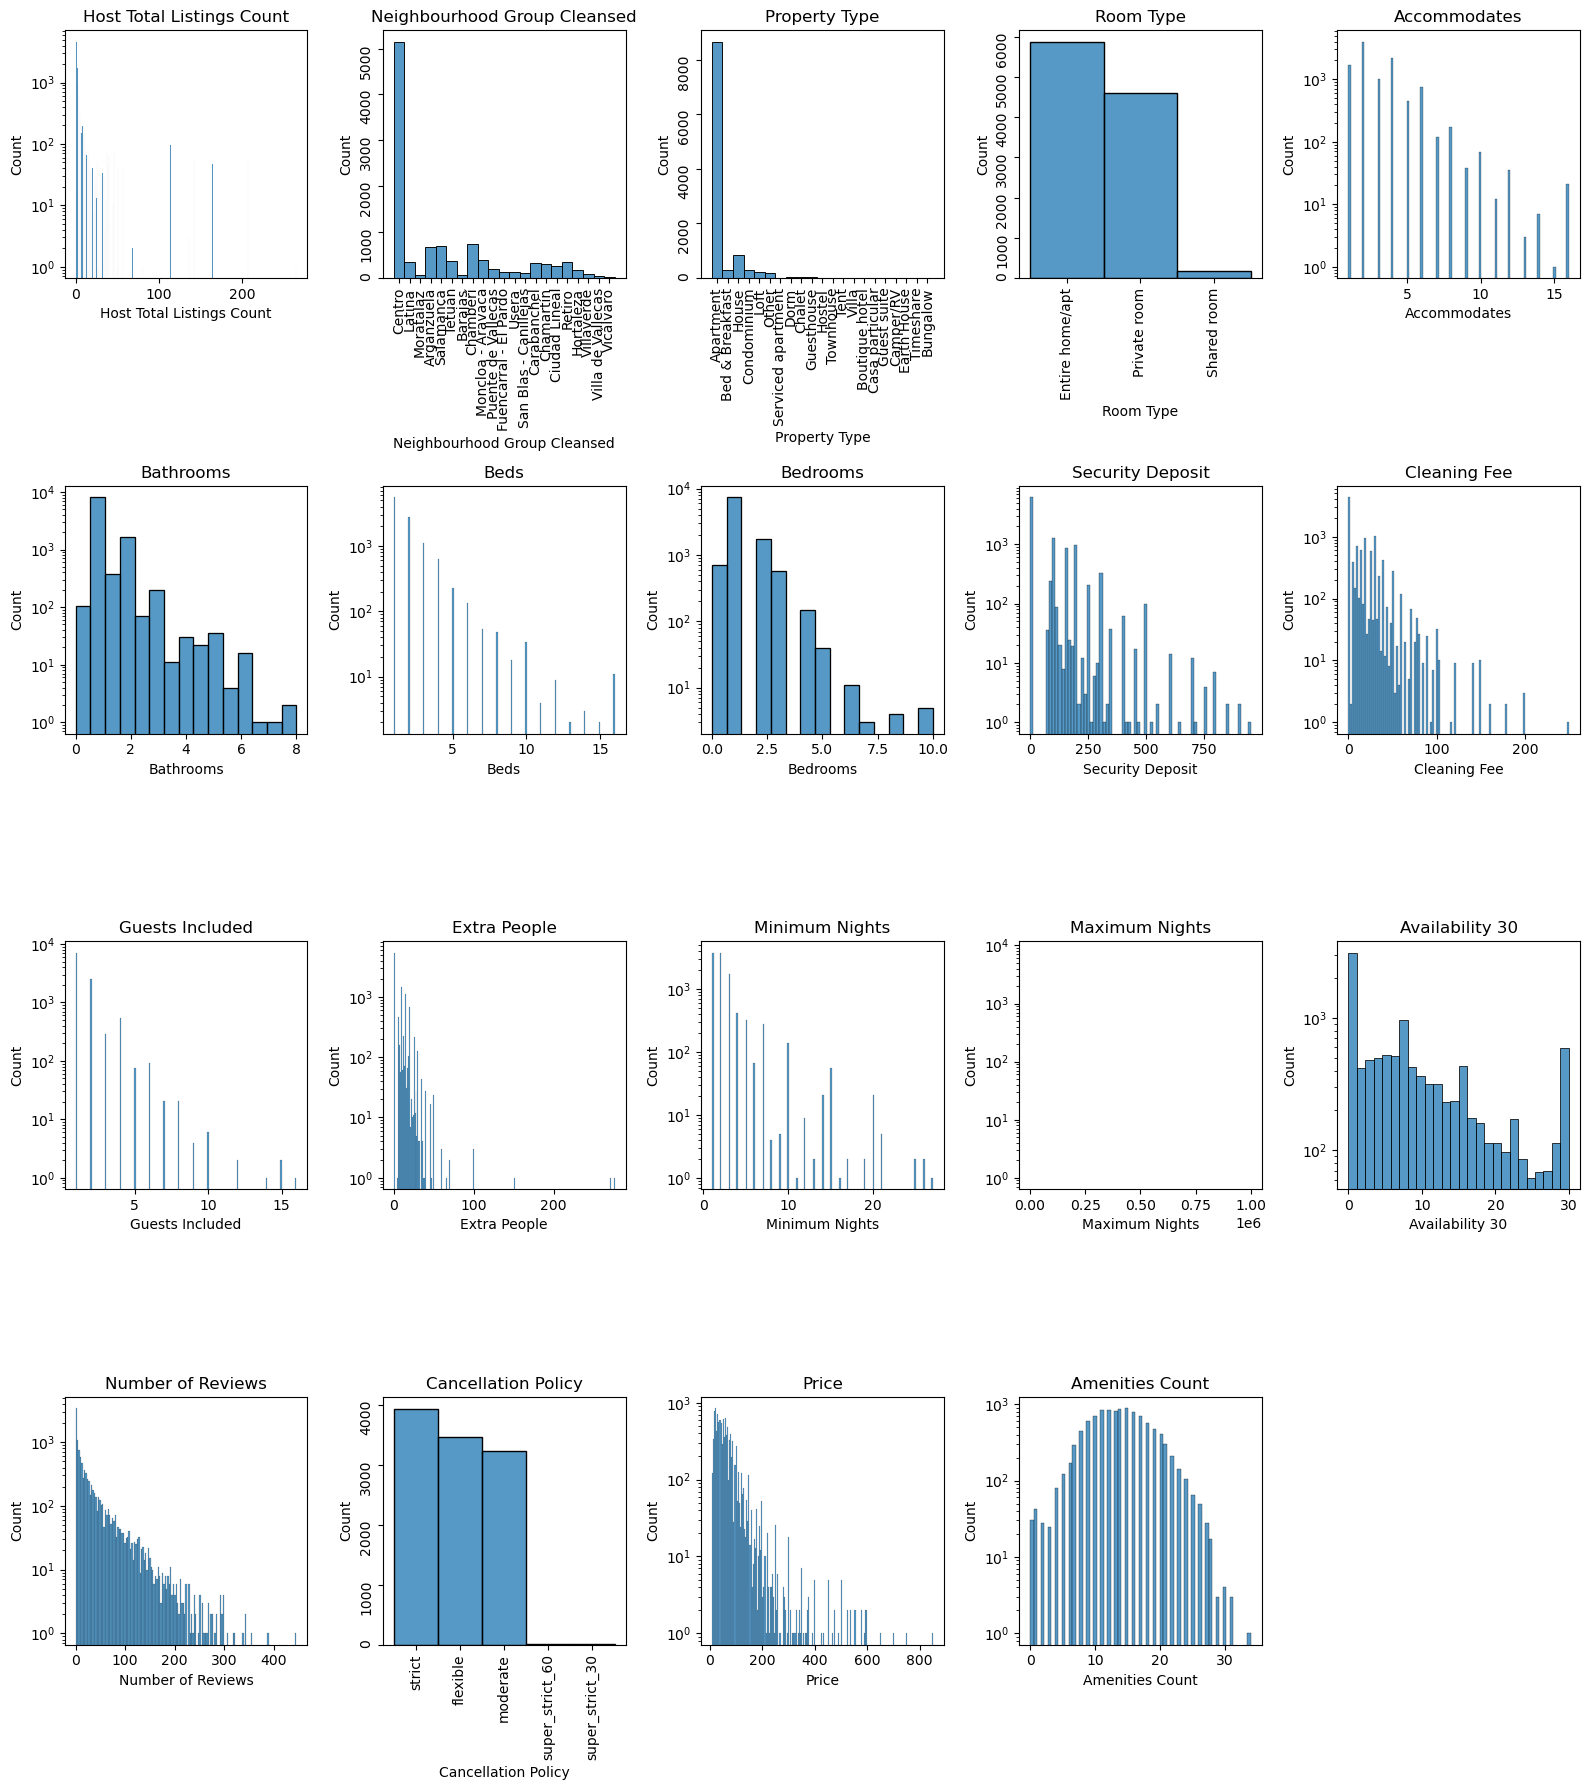

In [178]:
import math

df_plot = df_madrid.drop("Thumbnail Url", axis=1)
num_cols = len(df_plot.columns)
num_rows = math.ceil(num_cols / 5)

# Creo los subplots con los cálculos anteriores.
fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(16, num_rows * 4.5))

# Coloco los axes en fila para poderlos mover mejor.
axes = axes.flatten()

# Eliminamos las celdas que no tengan gráfica
for i in range(num_cols, num_rows * 5):
    fig.delaxes(axes[i])

# Loop para colocar secuencialmente las gráficas en sus subplots
for i, col in enumerate(df_plot.columns):
    # Creao un histograma para cada columna en el subplot correspondiente
    # Si es categórica, que ajuste el parámetro de hisplot() discrete=True
    
    if col in ["Neighbourhood Group Cleansed", "Property Type", "Room Type", "Cancellation Policy"]:
        # En las categóricas giraré las etiquetas
        sns.histplot(df_plot[col], ax=axes[i], discrete=True)
        axes[i].set_title(col)
        axes[i].tick_params(labelrotation=90)
    else:
        # Usaré una escala logarítmica en el eje y para resaltar los valores más pequeños
        sns.histplot(df_plot[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_yscale("log")
        
plt.tight_layout()
plt.show()

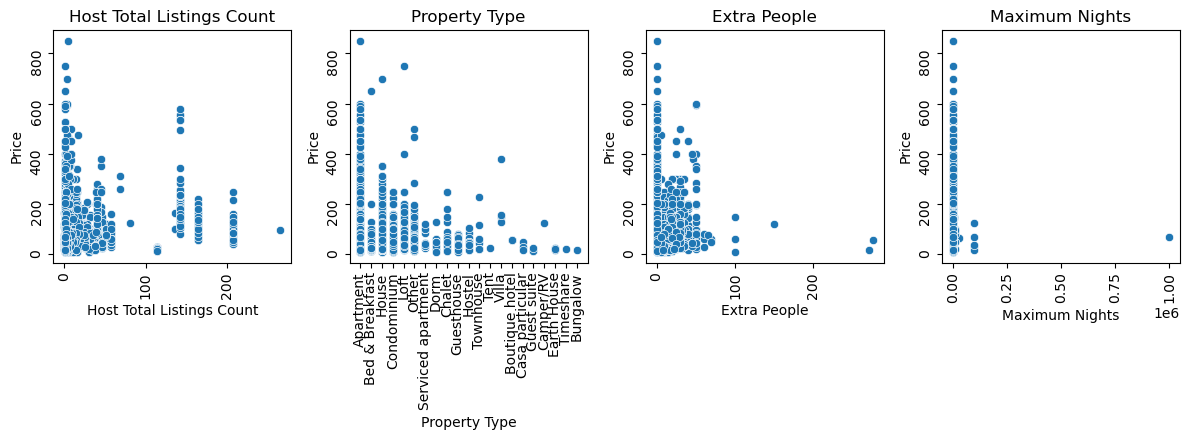

In [179]:
# Autoconfiguración de filas y columnas según el número de columnas del dataframe.
df_plot2 = df_madrid[["Host Total Listings Count", "Property Type", "Extra People", "Maximum Nights"]]
num_cols = len(df_plot2.columns)
num_rows = math.ceil(num_cols / 4) # Para calcular las filas dividimos por 4 columnas de ancho en cada fila, y redondeamos al más alto.

# Creo los subplots con los cálculos anteriores.
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, num_rows * 4.5))

# Coloco los axes en fila para poderlos mover mejor.
axes = axes.flatten()

# Eliminamos las celdas que no tengan gráfica
for i in range(num_cols, num_rows * 4):
    fig.delaxes(axes[i])

# Loop para colocar secuencialmente las gráficas en sus subplots
for i, col in enumerate(df_plot2.columns):
    # Creo un boxplot para cada columna en el subplot correspondiente
    sns.scatterplot(x=df_plot2[col], y=df_madrid["Price"], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

En casi todas las variables la distribución es right skewed, con valores distribuidos de manera continua, sin saltos grandes. Su continuidad indica que no son outliers.  
Sin embargo, en "Extra people" hay valores muy extremos muy separados de la distribución principal. Especialmente en "Maximum nights", hay valores tan extremos quye hace que el resto de la distribución no se vea. Vamos a tratar estos valores extremos.

#### Outliers:

* Analizamos "Extra People":

In [180]:
df_madrid["Extra People"].describe()

count    10649.000000
mean         7.163677
std          9.786382
min          0.000000
25%          0.000000
50%          0.000000
75%         13.000000
max        276.000000
Name: Extra People, dtype: float64

In [181]:
np.percentile(df_madrid["Extra People"],95)

24.0

In [182]:
# Veamos los 30 valores más altos
df_madrid[df_madrid["Extra People"] > 25].sort_values(by="Extra People")["Extra People"].tail(30)

4898      50
9729      50
12048     50
9991      50
5441      50
8014      50
11700     50
7692      50
7225      50
1976      50
7194      50
11868     50
6709      50
6913      50
6747      50
12198     50
9542      50
9397      50
2037      60
4797      60
12938     60
6150      65
13545     70
243       70
5190     100
8011     100
8284     100
4428     150
9297     271
3559     276
Name: Extra People, dtype: int64

En este caso se aprecian saltos muy grandes poco consecutivos al final de los datos ordenados. Sin embargo, siguen una cierta continuidad, y podrían ser valores verdaderos relacionados con hoteles u hostales. por los que lo conservaré.

* Ahora veremos "Maximum Nights":

In [183]:
df_madrid["Maximum Nights"].describe()

count      10649.000000
mean         983.006949
std         9937.468119
min            1.000000
25%          360.000000
50%         1125.000000
75%         1125.000000
max      1000000.000000
Name: Maximum Nights, dtype: float64

In [147]:
np.percentile(df_madrid["Maximum Nights"],95)

1125.0

In [185]:
# Veamos los 20 valores más altos
df_madrid[df_madrid["Maximum Nights"] > 25].sort_values(by="Maximum Nights")["Maximum Nights"].tail(24)

6004        2000
1010        2000
4604        2000
12294       2000
6875        5000
5747        5555
2147        9999
9304        9999
2386        9999
10270      10000
5222       10000
2344       10000
910        10000
2791       10000
2401       10000
10674      11111
6548       11111
3402       30000
4397       99999
2641       99999
7821       99999
2380       99999
4366      100000
281      1000000
Name: Maximum Nights, dtype: int64

Teniendo en cuenta que el 95% de los valores están por debajo de 1125, lo cual indica que no hay un mínimo de noches de alquiler, no parece razonable conservar valores más altos que 5000. Todos los que estén más allé de 5000 se transformarán a 5000. Dado que es un valor de conversión fijo y establecido de antemano, se puede hacer antes del split, ya que no es un valor calculado en base a sumatorias del resto de los valores y no influirá en el entrenamiento.

In [186]:
df_madrid.loc[df_madrid["Maximum Nights"] > 5000, "Maximum Nights"] = 5000

In [188]:
df_madrid[df_madrid["Maximum Nights"] > 25].sort_values(by="Maximum Nights")["Maximum Nights"].tail(30)

7812     1825
8228     1825
12097    1900
7529     1999
9874     2000
10110    2000
6004     2000
1010     2000
4604     2000
12294    2000
9304     5000
3402     5000
2386     5000
4366     5000
10270    5000
6875     5000
2147     5000
4397     5000
5747     5000
10674    5000
2791     5000
2401     5000
2641     5000
910      5000
281      5000
6548     5000
5222     5000
7821     5000
2344     5000
2380     5000
Name: Maximum Nights, dtype: int64

Volvamos a revisar el dataframe para continuar codificando las categóticas:

In [189]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10649 entries, 4 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10649 non-null  object 
 1   Host Total Listings Count     10649 non-null  float64
 2   Neighbourhood Group Cleansed  10649 non-null  object 
 3   Property Type                 10649 non-null  object 
 4   Room Type                     10649 non-null  object 
 5   Accommodates                  10649 non-null  int64  
 6   Bathrooms                     10649 non-null  float64
 7   Beds                          10649 non-null  float64
 8   Bedrooms                      10649 non-null  float64
 9   Security Deposit              10649 non-null  float64
 10  Cleaning Fee                  10649 non-null  float64
 11  Guests Included               10649 non-null  int64  
 12  Extra People                  10649 non-null  int64  
 13  Minimu

Tenemos varias features que son categóricas. Veamos qué se puede categorizar antes del split:  

In [190]:
df_madrid["Neighbourhood Group Cleansed"].unique()

array(['Centro', 'Latina', 'Moratalaz', 'Arganzuela', 'Salamanca',
       'Tetuán', 'Barajas', 'Chamberí', 'Moncloa - Aravaca',
       'Puente de Vallecas', 'Fuencarral - El Pardo', 'Usera',
       'San Blas - Canillejas', 'Carabanchel', 'Chamartín',
       'Ciudad Lineal', 'Retiro', 'Hortaleza', 'Villaverde',
       'Villa de Vallecas', 'Vicálvaro'], dtype=object)

In [191]:
df_madrid["Neighbourhood Group Cleansed"].nunique()

21

In [192]:
df_madrid["Property Type"].unique()

array(['Apartment', 'Bed & Breakfast', 'House', 'Condominium', 'Loft',
       'Other', 'Serviced apartment', 'Dorm', 'Chalet', 'Guesthouse',
       'Hostel', 'Townhouse', 'Tent', 'Villa', 'Boutique hotel',
       'Casa particular', 'Guest suite', 'Camper/RV', 'Earth House',
       'Timeshare', 'Bungalow'], dtype=object)

In [193]:
df_madrid["Property Type"].nunique()

21

In [194]:
df_madrid["Room Type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [195]:
df_madrid["Cancellation Policy"].unique()

array(['strict', 'flexible', 'moderate', 'super_strict_60',
       'super_strict_30'], dtype=object)

* Las dos variables de los barrios se pueden categorizar antes, ya que depende de su propio nombre, no de los valores de los demás registros.  
* Property Type y Room Type tienen categorías nominales que tampoco dependen de los valores de los demás registros.
* Cancellation Policy tampoco depende de los valores de las demás observaciones, así que se puede codificar antes del split.  
  

Todos los valores de las variables están predefinidas por AirBnb y no dependen de mediciones, razón añadida para poderlas codificar antes del split.

* Ahora codificaré "Cancellation Policy" con un LabelEncoding Ordinal, porque esta variable sí que es se hace más restrictiva según sube su categoría, desde un nivel 0 "Flexible" hasta un nivel 4 super estricto 60 días. Además, casualmente los nombres de las categorías ya están ordenados alfabéticamente de menos rígido a más rígido.

In [196]:
# Codificaré con sklearn, ya que tensorflow no permite como entradas strings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le_canc = LabelEncoder()
df_madrid["Cancellation Policy"] = le_canc.fit_transform(df_madrid["Cancellation Policy"])
# Veamos las categorías creadas y su correspondencia
listado_canc = [(idx,clase) for idx, clase in enumerate(le_canc.classes_)]
listado_canc

[(0, 'flexible'),
 (1, 'moderate'),
 (2, 'strict'),
 (3, 'super_strict_30'),
 (4, 'super_strict_60')]

In [197]:
df_madrid["Cancellation Policy"].head()

4     2
8     0
9     2
10    0
11    1
Name: Cancellation Policy, dtype: int64

In [198]:
df_madrid.describe()

,Host Total Listings Count,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
count,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000
mean,8.691145,3.075688,1.252841,1.936238,1.275988,74.212414,16.135506,1.553197,7.163677,2.410367,837.193258,8.403794,25.478636,1.045075,61.429524,13.937741
std,24.786946,1.965972,0.603838,1.495978,0.802178,110.366167,20.238648,1.076616,9.786382,2.209719,508.131887,8.694680,40.557337,0.834342,51.927425,4.740760
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,360.000000,0.000000,1.000000,0.000000,30.000000,11.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,10.000000,1.000000,0.000000,2.000000,1125.000000,6.000000,9.000000,1.000000,50.000000,14.000000
75%,5.000000,4.000000,1.000000,2.000000,1.000000,150.000000,25.000000,2.000000,13.000000,3.000000,1125.000000,13.000000,32.000000,2.000000,75.000000,17.000000
max,265.000000,16.000000,8.000000,16.000000,10.000000,950.000000,250.000000,16.000000,276.000000,27.000000,5000.000000,30.000000,446.000000,4.000000,850.000000,34.000000


* Ahora, las demás variables usando get_dummies:

In [199]:
df_madrid = pd.get_dummies(df_madrid, columns=["Room Type", "Property Type", "Neighbourhood Group Cleansed"], dtype=int)
df_madrid

,Thumbnail Url,Host Total Listings Count,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,Guests Included,Extra People,...,Neighbourhood Group Cleansed_Moratalaz,Neighbourhood Group Cleansed_Puente de Vallecas,Neighbourhood Group Cleansed_Retiro,Neighbourhood Group Cleansed_Salamanca,Neighbourhood Group Cleansed_San Blas - Canillejas,Neighbourhood Group Cleansed_Tetuán,Neighbourhood Group Cleansed_Usera,Neighbourhood Group Cleansed_Vicálvaro,Neighbourhood Group Cleansed_Villa de Vallecas,Neighbourhood Group Cleansed_Villaverde
4,https://a0.muscache.com/im/pictures/8a74bd1d-e...,164.0,4,1.0,1.0,1.0,200.0,50.0,2,10,...,0,0,0,0,0,0,0,0,0,0
8,https://a0.muscache.com/im/pictures/01e327f4-6...,1.0,1,1.0,1.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,https://a0.muscache.com/im/pictures/17315920/c...,1.0,4,1.0,2.0,1.0,500.0,20.0,2,15,...,0,0,0,0,0,0,0,0,0,0
10,https://a0.muscache.com/im/pictures/17469332-c...,2.0,1,1.0,1.0,1.0,0.0,0.0,1,0,...,1,0,0,0,0,0,0,0,0,0
11,https://a0.muscache.com/im/pictures/121291dc-3...,7.0,1,1.0,1.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,https://a0.muscache.com/im/pictures/6f12be9a-7...,1.0,1,1.0,1.0,1.0,0.0,10.0,1,22,...,0,0,0,0,0,0,0,0,0,0
13996,https://a0.muscache.com/im/pictures/eb603048-c...,1.0,4,1.0,1.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
13997,https://a0.muscache.com/im/pictures/11270498/b...,2.0,6,1.0,3.0,2.0,0.0,50.0,2,10,...,0,0,0,0,0,0,0,0,0,0
13998,https://a0.muscache.com/im/pictures/0e8bb248-5...,1.0,3,1.0,1.0,1.0,150.0,24.0,2,5,...,0,0,0,0,0,0,0,0,0,0


Sólo queda transformar todas las variables al mismo tipo de datos.  
Para ello vamos a inspeccionar primero los rangos de valores existentes antes de hacer el get_dummies (un chunk por encima de este), nos ayudará a reducir los bits del dtype:

* Podemos apreciar valores extremos de hasta 1 millón en la variable máximas noches, lo cual nos obliga a usar una alta profundidad de bits. Evidentemente, esto es un outlier, que trataremos después. Tras reducir outliers, puede que podamos optimizar el tipo de datos.

In [200]:
df_madrid[df_madrid.columns.difference(["Thumbnail Url"])] = df_madrid[df_madrid.columns.difference(["Thumbnail Url"])].astype("float64")
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10649 entries, 4 to 13999
Data columns (total 62 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Thumbnail Url                                       10649 non-null  object 
 1   Host Total Listings Count                           10649 non-null  float64
 2   Accommodates                                        10649 non-null  float64
 3   Bathrooms                                           10649 non-null  float64
 4   Beds                                                10649 non-null  float64
 5   Bedrooms                                            10649 non-null  float64
 6   Security Deposit                                    10649 non-null  float64
 7   Cleaning Fee                                        10649 non-null  float64
 8   Guests Included                                     10649 non-null  float64
 9   

Ya son del mismo tipo todas las variables, float64.

#### Preproc terminado.

---

<h2 align=center>ETAPA 2: EXTRACCIÓN DE IMÁGENES</h2>

Ahora que tenemos las filas que definitivamente vamos a conservar, haremos la extracción de las imágenes.

Primero, resetearé el índice para tener más coherencia.

In [204]:
df_madrid = df_madrid.reset_index()
df_madrid

,level_0,index,Thumbnail Url,Host Total Listings Count,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,...,Neighbourhood Group Cleansed_Moratalaz,Neighbourhood Group Cleansed_Puente de Vallecas,Neighbourhood Group Cleansed_Retiro,Neighbourhood Group Cleansed_Salamanca,Neighbourhood Group Cleansed_San Blas - Canillejas,Neighbourhood Group Cleansed_Tetuán,Neighbourhood Group Cleansed_Usera,Neighbourhood Group Cleansed_Vicálvaro,Neighbourhood Group Cleansed_Villa de Vallecas,Neighbourhood Group Cleansed_Villaverde
0,0,4,https://a0.muscache.com/im/pictures/8a74bd1d-e...,164.0,4.0,1.0,1.0,1.0,200.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,8,https://a0.muscache.com/im/pictures/01e327f4-6...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,9,https://a0.muscache.com/im/pictures/17315920/c...,1.0,4.0,1.0,2.0,1.0,500.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,10,https://a0.muscache.com/im/pictures/17469332-c...,2.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,11,https://a0.muscache.com/im/pictures/121291dc-3...,7.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10644,10644,13995,https://a0.muscache.com/im/pictures/6f12be9a-7...,1.0,1.0,1.0,1.0,1.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10645,10645,13996,https://a0.muscache.com/im/pictures/eb603048-c...,1.0,4.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10646,10646,13997,https://a0.muscache.com/im/pictures/11270498/b...,2.0,6.0,1.0,3.0,2.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10647,10647,13998,https://a0.muscache.com/im/pictures/0e8bb248-5...,1.0,3.0,1.0,1.0,1.0,150.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=np.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

In [206]:
images_raw, idxs = download_images(df_madrid['Thumbnail Url'])
plt.imshow(images[1])



100%|███████████████████████████████████| 10649/10649 [1:09:38<00:00,  2.55it/s]


NameError: name 'images' is not defined

In [214]:
images = images_raw.astype("float32") / 255.
images.shape

(8293, 224, 224, 3)

In [215]:
len(idxs)

8293

In [216]:
filtered_df = df_madrid.iloc[idxs]
filtered_df

,level_0,index,Thumbnail Url,Host Total Listings Count,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,...,Neighbourhood Group Cleansed_Moratalaz,Neighbourhood Group Cleansed_Puente de Vallecas,Neighbourhood Group Cleansed_Retiro,Neighbourhood Group Cleansed_Salamanca,Neighbourhood Group Cleansed_San Blas - Canillejas,Neighbourhood Group Cleansed_Tetuán,Neighbourhood Group Cleansed_Usera,Neighbourhood Group Cleansed_Vicálvaro,Neighbourhood Group Cleansed_Villa de Vallecas,Neighbourhood Group Cleansed_Villaverde
0,0,4,https://a0.muscache.com/im/pictures/8a74bd1d-e...,164.0,4.0,1.0,1.0,1.0,200.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,8,https://a0.muscache.com/im/pictures/01e327f4-6...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,9,https://a0.muscache.com/im/pictures/17315920/c...,1.0,4.0,1.0,2.0,1.0,500.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,10,https://a0.muscache.com/im/pictures/17469332-c...,2.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,13,https://a0.muscache.com/im/pictures/c07ba9c3-9...,1.0,2.0,1.0,2.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10643,10643,13993,https://a0.muscache.com/im/pictures/105195120/...,11.0,8.0,2.0,4.0,2.0,0.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10645,10645,13996,https://a0.muscache.com/im/pictures/eb603048-c...,1.0,4.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10646,10646,13997,https://a0.muscache.com/im/pictures/11270498/b...,2.0,6.0,1.0,3.0,2.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10647,10647,13998,https://a0.muscache.com/im/pictures/0e8bb248-5...,1.0,3.0,1.0,1.0,1.0,150.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
np.save('images.npy', images)
filtered_df.to_csv('filtered_data.csv', sep=';', index=False)

In [ ]:
# Comprobamos a abrirlos de nuevo
saved_data = pd.read_csv("filtered_data.csv", sep=';')
saved_imgs = np.load("images.npy")
saved_data.shape, saved_imgs.shape

((8293, 64), (8293, 224, 224, 3))

---

<h2 align=center>ETAPA 3: SPLIT DE DATOS</h2>

<h2 align=center>ETAPA 4: MODELADO Y TRATAMIENTO PREVIO</h2>